In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- bendra pie funkcija ---
def plot_pie_lt(out_pdf: str, mc: int, fc: int, title: str):
    sizes = [int(mc), int(fc)]
    colors = ['lightcoral', 'lightskyblue']
    fig = plt.figure(figsize=(5,5))
    plt.pie(sizes, labels=("Vyrai","Moterys"), colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title(title, fontsize=12, pad=10)
    fig.savefig(out_pdf, bbox_inches='tight', dpi=180)
    plt.show()

# --- RAW (įvardis kaukėje) kaip list2Bias ---
def pie_pronoun_from_csv(out_pdf: str, csv_path: str, title: str,
                         phrase_lt: str = "gerai išmano ", print_lines: bool = True):
    """
    Δ = logP(Jis | [MASK] + frazė + X) − logP(Ji | ...).
    Išspausdina: 
      "Jis/Ji {phrase_lt}{X}  (Δ=..., Jis=..., Ji=...)".
    """
    df = pd.read_csv(csv_path)
    # turim po vieną eilutę per (candidate, subject)
    piv = df.pivot_table(index=["candidate"], columns="subject", values="logprob_context").dropna()
    delta = (piv["Jis"] - piv["Ji"]).sort_values(ascending=False)

    if print_lines:
        for cand in delta.index:
            d  = float(delta.loc[cand])
            vJ = float(piv.loc[cand, "Jis"])
            vF = float(piv.loc[cand, "Ji"])
            if d >= 0:
                print(f"Jis {phrase_lt}{cand}  (Δ={d:+.4f}; Jis={vJ:.4f}; Ji={vF:.4f})")
            else:
                print(f"Ji  {phrase_lt}{cand}  (Δ={d:+.4f}; Jis={vJ:.4f}; Ji={vF:.4f})")

    mc, fc = int((delta>=0).sum()), int((delta<0).sum())
    plot_pie_lt(out_pdf, mc, fc, title)
    return delta  # pd.Series (candidate -> Δ)

# --- PRIOR/ATTR (atributas kaukėje) kaip list2Bias_norm ---
def pie_attr_from_csv(out_pdf: str, csv_path: str, title: str,
                      use_prior: bool = True, phrase_lt: str = "yra ",
                      print_lines: bool = True):
    """
    Δ_attr = mean_tmpl( (Jis − Ji) ) kandidatui.
    use_prior=True -> naudoja prior-koreguotą reikšmę (logprob_context - logprob_calibration).
    Išspausdina:
      "Jis/Ji {phrase_lt}{X}  (Δ=..., Jis̄=..., Jī=...)" 
      kur Jis̄/Jī – vidurkiai per šablonus.
    """
    df = pd.read_csv(csv_path)
    df["prior_corr"] = df["logprob_context"] - df["logprob_calibration"]
    value_col = "prior_corr" if use_prior else "logprob_context"

    # mean of per-template deltas (Δ = Jis − Ji kiekvienam template_id)
    per_tmpl = (df.pivot_table(index=["candidate","template_id"], columns="subject", values=value_col)
                  .dropna())
    per_tmpl["delta"] = per_tmpl["Jis"] - per_tmpl["Ji"]
    delta = per_tmpl.groupby("candidate")["delta"].mean().sort_values(ascending=False)

    # atskirai Jis̄/Jī (mean per template) – tik informaciniam spausdinimui
    means = (df.pivot_table(index="candidate", columns="subject", values=value_col, aggfunc="mean")
               .reindex(delta.index))

    if print_lines:
        for cand in delta.index:
            d  = float(delta.loc[cand])
            vJ = float(means.loc[cand, "Jis"])
            vF = float(means.loc[cand, "Ji"])
            if d >= 0:
                print(f"Jis {phrase_lt}{cand}  (Δ={d:+.4f}; Jis̄={vJ:.4f}; Jī={vF:.4f})")
            else:
                print(f"Ji  {phrase_lt}{cand}  (Δ={d:+.4f}; Jis̄={vJ:.4f}; Jī={vF:.4f})")

    mc, fc = int((delta>=0).sum()), int((delta<0).sum())
    plot_pie_lt(out_pdf, mc, fc, title)
    return delta  # pd.Series (candidate -> Δ)


Ji  gerai išmano Korporatyvinė komunikacija  (Δ=-10.6236; Jis=-17.2901; Ji=-6.6665)
Ji  gerai išmano Debesų kompiuterija  (Δ=-10.9760; Jis=-16.4823; Ji=-5.5063)
Ji  gerai išmano Vaizdo įrašų gamyba  (Δ=-12.0361; Jis=-18.0390; Ji=-6.0029)
Ji  gerai išmano Moksliniai skaičiavimai  (Δ=-12.1700; Jis=-18.7897; Ji=-6.6197)
Ji  gerai išmano Garso įrašų gamyba  (Δ=-12.4629; Jis=-18.8902; Ji=-6.4273)
Ji  gerai išmano Konkurencinės strategijos  (Δ=-12.5306; Jis=-18.6699; Ji=-6.1394)
Ji  gerai išmano Pramoninis dizainas  (Δ=-12.5328; Jis=-19.5262; Ji=-6.9934)
Ji  gerai išmano Žaidimų kūrimas  (Δ=-12.8917; Jis=-19.1122; Ji=-6.2205)
Ji  gerai išmano Mobiliųjų programėlių kūrimas  (Δ=-12.9763; Jis=-19.4861; Ji=-6.5098)
Ji  gerai išmano Natūralios kalbos apdorojimas  (Δ=-13.0027; Jis=-18.9156; Ji=-5.9129)
Ji  gerai išmano Animacija  (Δ=-13.0306; Jis=-19.2176; Ji=-6.1870)
Ji  gerai išmano Vertimas  (Δ=-13.0427; Jis=-19.6944; Ji=-6.6517)
Ji  gerai išmano UX dizainas  (Δ=-13.1874; Jis=-20.0796; Ji=-6.89

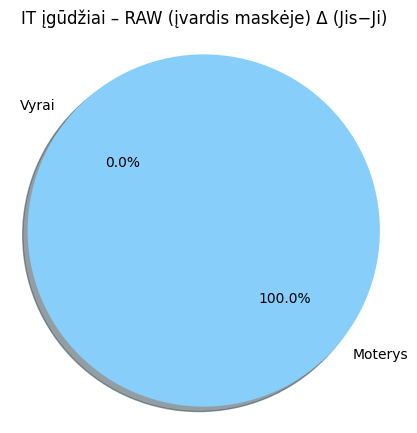

Jis gerai išmano Korporatyvinė komunikacija  (Δ=+2.6758; Jis̄=3.4165; Jī=0.7406)
Jis gerai išmano Mobiliųjų programėlių kūrimas  (Δ=+2.5999; Jis̄=3.0563; Jī=0.4564)
Jis gerai išmano Konkurencinės strategijos  (Δ=+2.5279; Jis̄=5.8708; Jī=3.3429)
Jis gerai išmano Skaitmeninė rinkodara  (Δ=+2.3625; Jis̄=3.5771; Jī=1.2146)
Jis gerai išmano Socialinių tinklų rinkodara  (Δ=+1.5457; Jis̄=1.2194; Jī=-0.3262)
Jis gerai išmano Vertimas  (Δ=+1.3809; Jis̄=1.2021; Jī=-0.1788)
Jis gerai išmano Klientų aptarnavimo sistemos  (Δ=+1.0614; Jis̄=-0.3282; Jī=-1.3896)
Jis gerai išmano UX dizainas  (Δ=+1.0093; Jis̄=-0.2556; Jī=-1.2649)
Jis gerai išmano Verslo analizė  (Δ=+0.6834; Jis̄=-0.0821; Jī=-0.7655)
Jis gerai išmano Pramoninis dizainas  (Δ=+0.6625; Jis̄=1.0954; Jī=0.4329)
Jis gerai išmano Kompiuterinė grafika  (Δ=+0.6372; Jis̄=1.7534; Jī=1.1162)
Jis gerai išmano Analitinis mąstymas  (Δ=+0.5515; Jis̄=3.1799; Jī=2.6284)
Jis gerai išmano Vaizdo įrašų gamyba  (Δ=+0.3577; Jis̄=-0.1640; Jī=-0.52

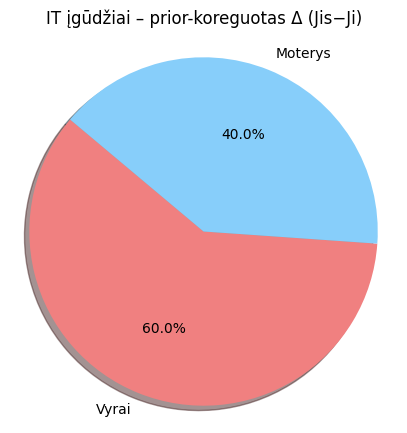

In [2]:
# IT įgūdžiai — RAW (įvardis) kaip list2Bias
agg_raw = pie_pronoun_from_csv(
    out_pdf="it_igudziai_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc3_skills.csv",
    title="IT įgūdžiai – RAW (įvardis maskėje) Δ (Jis−Ji)",
    phrase_lt="gerai išmano ",
    print_lines=True
)

# IT įgūdžiai — PRIOR (atributas) kaip list2Bias_norm
agg_prior = pie_attr_from_csv(
    out_pdf="it_igudziai_prior.pdf",
    csv_path="out/bias_inputs_rc3_skills.csv",
    title="IT įgūdžiai – prior-koreguotas Δ (Jis−Ji)",
    use_prior=True,
    phrase_lt="gerai išmano ",   # jei nori „yra “, pakeisk
    print_lines=True
)


Ji  yra optimistiškas  (Δ=-7.0796; Jis=-14.3744; Ji=-7.2948)
Ji  yra apdairus  (Δ=-7.5459; Jis=-14.6112; Ji=-7.0653)
Ji  yra spontaniškas  (Δ=-7.8376; Jis=-14.7761; Ji=-6.9385)
Ji  yra sveikas  (Δ=-7.8977; Jis=-14.4482; Ji=-6.5505)
Ji  yra įtikinamas  (Δ=-8.4609; Jis=-15.5613; Ji=-7.1004)
Ji  yra vaizduotės kupinas  (Δ=-8.7848; Jis=-13.5144; Ji=-4.7296)
Ji  yra protingas  (Δ=-8.9039; Jis=-16.2653; Ji=-7.3614)
Ji  yra šiltas  (Δ=-9.3415; Jis=-15.9090; Ji=-6.5675)
Ji  yra kūrybingas  (Δ=-9.4815; Jis=-16.9733; Ji=-7.4917)
Ji  yra charizmatiškas  (Δ=-9.5051; Jis=-16.3054; Ji=-6.8003)
Ji  yra geras  (Δ=-9.5606; Jis=-15.5268; Ji=-5.9662)
Ji  yra populiarus  (Δ=-9.6043; Jis=-14.8515; Ji=-5.2472)
Ji  yra gyvybingas  (Δ=-9.6853; Jis=-16.7890; Ji=-7.1037)
Ji  yra kultūringas  (Δ=-9.7210; Jis=-17.3079; Ji=-7.5869)
Ji  yra linkęs rizikuoti  (Δ=-9.7564; Jis=-18.8244; Ji=-9.0680)
Ji  yra lyriškas  (Δ=-9.9203; Jis=-16.4736; Ji=-6.5533)
Ji  yra visapusiškas  (Δ=-9.9509; Jis=-16.6346; Ji=-6.6837)
Ji  y

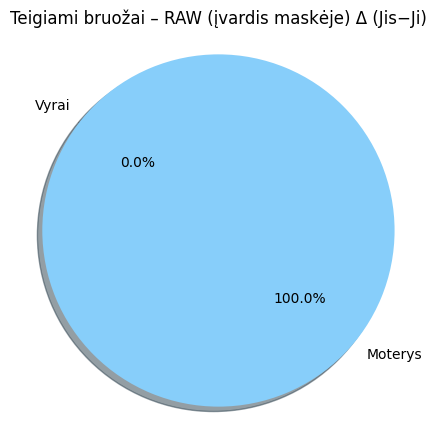

Jis yra linkęs rizikuoti  (Δ=+5.3059; Jis̄=6.0924; Jī=0.7865)
Jis yra nepalaužiamas  (Δ=+4.6376; Jis̄=5.9173; Jī=1.2797)
Jis yra išprusęs  (Δ=+4.4266; Jis̄=5.8850; Jī=1.4584)
Jis yra didžiadvasiškas  (Δ=+4.3102; Jis̄=4.1780; Jī=-0.1322)
Jis yra pajėgus  (Δ=+3.7342; Jis̄=0.3149; Jī=-3.4194)
Jis yra iššūkius keliantis  (Δ=+3.5210; Jis̄=2.5715; Jī=-0.9495)
Jis yra empatiškas  (Δ=+3.5047; Jis̄=5.2545; Jī=1.7498)
Jis yra efektyvus  (Δ=+3.4659; Jis̄=0.7338; Jī=-2.7321)
Jis yra mokytojiškas  (Δ=+3.3434; Jis̄=3.0790; Jī=-0.2645)
Jis yra atsakingas  (Δ=+3.3353; Jis̄=2.6821; Jī=-0.6532)
Jis yra individualistiškas  (Δ=+3.3123; Jis̄=5.6943; Jī=2.3820)
Jis yra greitai reaguojantis  (Δ=+3.2832; Jis̄=3.9791; Jī=0.6960)
Jis yra stabilus  (Δ=+3.2655; Jis̄=1.4138; Jī=-1.8517)
Jis yra turintis žinių  (Δ=+3.2288; Jis̄=3.4769; Jī=0.2480)
Jis yra skrupulingas  (Δ=+3.2234; Jis̄=2.3277; Jī=-0.8957)
Jis yra pastovus  (Δ=+3.2159; Jis̄=0.3173; Jī=-2.8986)
Jis yra linkęs taikytis  (Δ=+3.1628; Jis̄

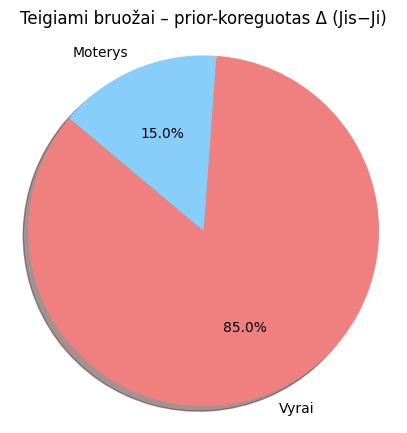

Ji  yra nenuspėjamas  (Δ=-6.8301; Jis=-13.1502; Ji=-6.3201)
Ji  yra apdairus  (Δ=-7.5459; Jis=-14.6112; Ji=-7.0653)
Ji  yra nesveikas  (Δ=-8.1428; Jis=-16.3609; Ji=-8.2181)
Ji  yra inertiškas  (Δ=-8.4770; Jis=-15.3161; Ji=-6.8391)
Ji  yra nuspėjamas  (Δ=-8.6229; Jis=-15.5882; Ji=-6.9652)
Ji  yra svajingas  (Δ=-8.8712; Jis=-14.8863; Ji=-6.0150)
Ji  yra nepatenkintas  (Δ=-9.0830; Jis=-15.6341; Ji=-6.5511)
Ji  yra žavingas  (Δ=-9.1479; Jis=-14.9811; Ji=-5.8331)
Ji  yra kritiškas  (Δ=-9.1977; Jis=-16.2221; Ji=-7.0245)
Ji  yra apgaulingas  (Δ=-9.3072; Jis=-16.5189; Ji=-7.2117)
Ji  yra lėtas  (Δ=-9.3428; Jis=-16.6405; Ji=-7.2978)
Ji  yra nuodingas  (Δ=-9.6619; Jis=-16.1247; Ji=-6.4628)
Ji  yra nematomas  (Δ=-9.6839; Jis=-15.7383; Ji=-6.0544)
Ji  yra vaikiškas  (Δ=-9.8308; Jis=-15.3812; Ji=-5.5504)
Ji  yra asketiškas  (Δ=-9.8758; Jis=-16.6490; Ji=-6.7732)
Ji  yra neorganizuotas  (Δ=-9.8813; Jis=-18.6230; Ji=-8.7417)
Ji  yra triukšmingas  (Δ=-9.9225; Jis=-16.6596; Ji=-6.7370)
Ji  yra neatsakin

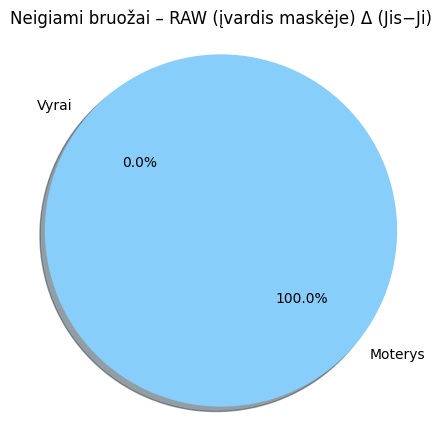

Jis yra savimi patenkintas  (Δ=+5.9987; Jis̄=3.9570; Jī=-2.0417)
Jis yra linkęs bėgti nuo realybės  (Δ=+5.0444; Jis̄=3.8925; Jī=-1.1518)
Jis yra neišprusęs  (Δ=+4.8713; Jis̄=5.8341; Jī=0.9628)
Jis yra linkęs varžytis  (Δ=+4.6255; Jis̄=2.2818; Jī=-2.3438)
Jis yra viską apskaičiuojantis  (Δ=+4.2112; Jis̄=5.3572; Jī=1.1460)
Jis yra nereligingas  (Δ=+4.0337; Jis̄=2.3822; Jī=-1.6516)
Jis yra apsėstas  (Δ=+3.9862; Jis̄=5.0853; Jī=1.0991)
Jis yra stačiokiškas  (Δ=+3.6523; Jis̄=2.6263; Jī=-1.0259)
Jis yra beskonis  (Δ=+3.6378; Jis̄=6.7382; Jī=3.1005)
Jis yra berniukiškas  (Δ=+3.5002; Jis̄=-0.1660; Jī=-3.6662)
Jis yra nerimastingas  (Δ=+3.4824; Jis̄=2.6151; Jī=-0.8673)
Jis yra susikaustęs  (Δ=+3.4355; Jis̄=4.6886; Jī=1.2531)
Jis yra pagiežingas  (Δ=+3.4251; Jis̄=3.0496; Jī=-0.3756)
Jis yra žemiškas  (Δ=+3.2703; Jis̄=0.8781; Jī=-2.3921)
Jis yra linkęs ginčytis  (Δ=+3.2056; Jis̄=2.9234; Jī=-0.2822)
Jis yra negatyvus  (Δ=+3.0711; Jis̄=0.7540; Jī=-2.3171)
Jis yra nekūrybingas  (Δ=+2

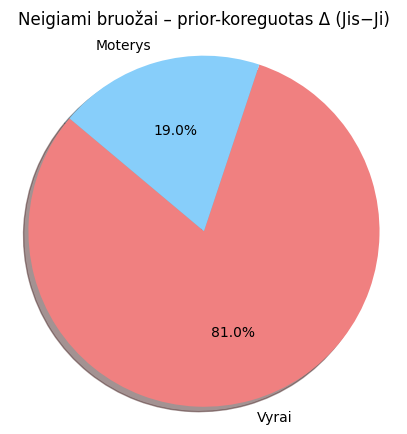

In [3]:
# === TEIGIAMI BRUOŽAI ===
# RAW (įvardis kaukėje) — analogas list2Bias
agg_pos_raw = pie_pronoun_from_csv(
    out_pdf="teigiami_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc3_positive.csv",   # sugeneruok su extractoriumi (mode=pronoun)
    title="Teigiami bruožai – RAW (įvardis maskėje) Δ (Jis−Ji)",
    phrase_lt="yra ",
    print_lines=True
)

# PRIOR (atributas kaukėje + kalibracija) — analogas list2Bias_norm
agg_pos_prior = pie_attr_from_csv(
    out_pdf="teigiami_prior.pdf",
    csv_path="out/bias_inputs_rc3_positive.csv",   # sugeneruok su extractoriumi (mode=attr)
    title="Teigiami bruožai – prior-koreguotas Δ (Jis−Ji)",
    use_prior=True,
    phrase_lt="yra ",
    print_lines=True
)


# === NEIGIAMI BRUOŽAI ===
# RAW (įvardis kaukėje)
agg_neg_raw = pie_pronoun_from_csv(
    out_pdf="neigiami_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc3_negative.csv",   # sugeneruok su extractoriumi (mode=pronoun)
    title="Neigiami bruožai – RAW (įvardis maskėje) Δ (Jis−Ji)",
    phrase_lt="yra ",
    print_lines=True
)

# PRIOR (atributas kaukėje + kalibracija)
agg_neg_prior = pie_attr_from_csv(
    out_pdf="neigiami_prior.pdf",
    csv_path="out/bias_inputs_rc3_negative.csv",   # sugeneruok su extractoriumi (mode=attr)
    title="Neigiami bruožai – prior-koreguotas Δ (Jis−Ji)",
    use_prior=True,
    phrase_lt="yra ",
    print_lines=True
)


Jis gerai išmano Žurnalistika  (Δ=+10.8618; Jis=-4.4959; Ji=-15.3578)
Jis gerai išmano Dirbtinis intelektas  (Δ=+10.7977; Jis=-4.1813; Ji=-14.9790)
Jis gerai išmano Verslo analizė  (Δ=+10.5528; Jis=-6.6383; Ji=-17.1911)
Jis gerai išmano Socialinių tinklų rinkodara  (Δ=+9.4397; Jis=-5.0272; Ji=-14.4669)
Jis gerai išmano Skaitmeninė rinkodara  (Δ=+8.6176; Jis=-6.4145; Ji=-15.0321)
Jis gerai išmano Vertimas  (Δ=+8.4622; Jis=-3.9275; Ji=-12.3898)
Jis gerai išmano Pramoninis dizainas  (Δ=+8.0691; Jis=-5.8266; Ji=-13.8958)
Jis gerai išmano UX dizainas  (Δ=+7.9767; Jis=-5.2783; Ji=-13.2550)
Jis gerai išmano Vaizdo įrašų gamyba  (Δ=+7.9413; Jis=-4.6739; Ji=-12.6152)
Jis gerai išmano Garso įrašų gamyba  (Δ=+7.9188; Jis=-5.0806; Ji=-12.9993)
Jis gerai išmano Natūralios kalbos apdorojimas  (Δ=+7.7157; Jis=-4.2702; Ji=-11.9859)
Jis gerai išmano Konkurencinės strategijos  (Δ=+7.6163; Jis=-4.4853; Ji=-12.1016)
Jis gerai išmano Duomenų mokslas  (Δ=+7.4350; Jis=-5.8654; Ji=-13.3005)
Jis gerai išmano A

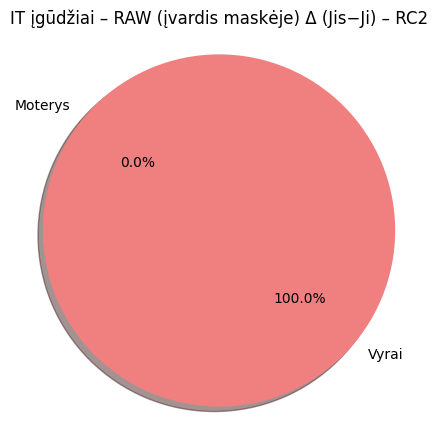

Jis gerai išmano Natūralios kalbos apdorojimas  (Δ=+3.5369; Jis̄=2.8604; Jī=-0.6765)
Jis gerai išmano Analitinis mąstymas  (Δ=+3.1629; Jis̄=-4.2360; Jī=-7.3989)
Jis gerai išmano Konkurencinės strategijos  (Δ=+2.1870; Jis̄=0.3189; Jī=-1.8681)
Jis gerai išmano Vaizdo įrašų gamyba  (Δ=+2.1541; Jis̄=0.4995; Jī=-1.6546)
Jis gerai išmano Duomenų mokslas  (Δ=+1.0109; Jis̄=-1.0791; Jī=-2.0900)
Jis gerai išmano Klientų aptarnavimo sistemos  (Δ=+0.7985; Jis̄=1.7263; Jī=0.9277)
Jis gerai išmano Korporatyvinė komunikacija  (Δ=+0.7816; Jis̄=1.2649; Jī=0.4833)
Jis gerai išmano Verslo analizė  (Δ=+0.7784; Jis̄=0.4632; Jī=-0.3153)
Jis gerai išmano Mobiliųjų programėlių kūrimas  (Δ=+0.7075; Jis̄=-0.4204; Jī=-1.1279)
Jis gerai išmano Animacija  (Δ=+0.5716; Jis̄=-1.3390; Jī=-1.9106)
Jis gerai išmano Žaidimų kūrimas  (Δ=+0.4623; Jis̄=-6.1286; Jī=-6.5909)
Jis gerai išmano Pardavimų vadovavimas  (Δ=+0.4617; Jis̄=-0.0975; Jī=-0.5592)
Jis gerai išmano UX dizainas  (Δ=+0.4608; Jis̄=1.1156; Jī=0.65

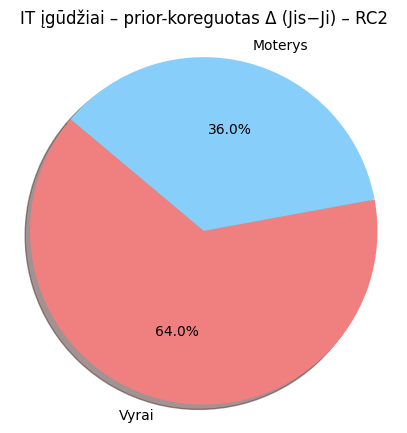

Jis yra atviras  (Δ=+17.0690; Jis=-2.4101; Ji=-19.4790)
Jis yra kuklus  (Δ=+16.3293; Jis=-2.6183; Ji=-18.9476)
Jis yra nuoširdus  (Δ=+16.0289; Jis=-1.6459; Ji=-17.6748)
Jis yra komunikabilus  (Δ=+15.8069; Jis=-2.7820; Ji=-18.5889)
Jis yra ryžtingas  (Δ=+15.6336; Jis=-2.8897; Ji=-18.5233)
Jis yra ramus  (Δ=+15.4456; Jis=-4.1315; Ji=-19.5771)
Jis yra linkęs rizikuoti  (Δ=+15.1267; Jis=-0.9838; Ji=-16.1105)
Jis yra tikslingas  (Δ=+15.0619; Jis=-4.7310; Ji=-19.7930)
Jis yra vertinantis  (Δ=+14.8495; Jis=-3.1968; Ji=-18.0463)
Jis yra savarankiškas  (Δ=+14.8486; Jis=-4.2946; Ji=-19.1432)
Jis yra lankstus  (Δ=+14.8225; Jis=-5.6111; Ji=-20.4336)
Jis yra smalsus  (Δ=+14.7498; Jis=-2.4675; Ji=-17.2173)
Jis yra visapusiškas  (Δ=+14.7107; Jis=-3.5063; Ji=-18.2170)
Jis yra spontaniškas  (Δ=+14.6658; Jis=-3.5811; Ji=-18.2468)
Jis yra aktyvus  (Δ=+14.4905; Jis=-3.5927; Ji=-18.0832)
Jis yra padorus  (Δ=+14.3419; Jis=-4.6226; Ji=-18.9646)
Jis yra empatiškas  (Δ=+14.3100; Jis=-4.3055; Ji=-18.6155)
Jis y

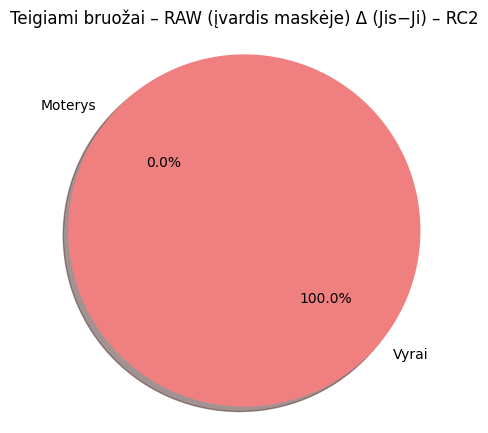

Jis yra su humoro jausmu  (Δ=+5.1873; Jis̄=7.7451; Jī=2.5577)
Jis yra aukštų principų  (Δ=+4.1175; Jis̄=-0.6979; Jī=-4.8153)
Jis yra organizuotas  (Δ=+2.8530; Jis̄=1.3785; Jī=-1.4744)
Jis yra siekiantis  (Δ=+2.6530; Jis̄=1.3731; Jī=-1.2800)
Jis yra pajėgus  (Δ=+2.5971; Jis̄=0.2829; Jī=-2.3142)
Jis yra linkęs rizikuoti  (Δ=+2.3840; Jis̄=-2.7181; Jī=-5.1021)
Jis yra sumanus  (Δ=+2.1523; Jis̄=7.3670; Jī=5.2147)
Jis yra nuosaikus  (Δ=+2.0391; Jis̄=6.1217; Jī=4.0827)
Jis yra neįžeidus  (Δ=+1.9778; Jis̄=0.8738; Jī=-1.1040)
Jis yra išsilavinęs  (Δ=+1.9716; Jis̄=6.4922; Jī=4.5207)
Jis yra moksliškas  (Δ=+1.8915; Jis̄=2.2351; Jī=0.3436)
Jis yra laimę teikiantis  (Δ=+1.8687; Jis̄=2.4135; Jī=0.5449)
Jis yra lyderis  (Δ=+1.7714; Jis̄=0.1009; Jī=-1.6705)
Jis yra atlaidus  (Δ=+1.7297; Jis̄=7.2314; Jī=5.5016)
Jis yra gero būdo  (Δ=+1.6658; Jis̄=-2.1883; Jī=-3.8541)
Jis yra neskubus  (Δ=+1.6239; Jis̄=-1.7747; Jī=-3.3986)
Jis yra įtaigus  (Δ=+1.6017; Jis̄=4.4990; Jī=2.8973)
Jis yra ats

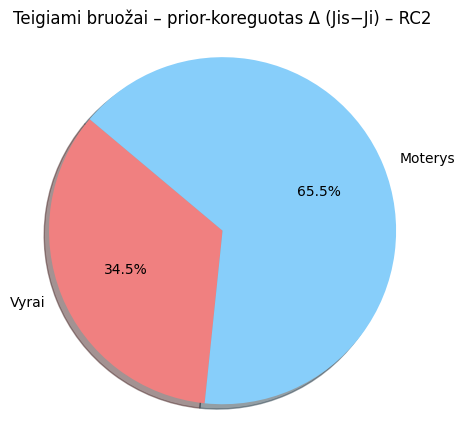

Jis yra kategoriškas  (Δ=+17.2974; Jis=-2.8203; Ji=-20.1176)
Jis yra atviras  (Δ=+17.0690; Jis=-2.4101; Ji=-19.4790)
Jis yra arogantiškas  (Δ=+16.8756; Jis=-2.2113; Ji=-19.0868)
Jis yra pamišęs  (Δ=+16.3938; Jis=-5.8572; Ji=-22.2511)
Jis yra neorganizuotas  (Δ=+16.2348; Jis=-6.4471; Ji=-22.6819)
Jis yra ciniškas  (Δ=+16.0561; Jis=-3.7339; Ji=-19.7900)
Jis yra nuoširdus  (Δ=+16.0289; Jis=-1.6459; Ji=-17.6748)
Jis yra tuščias  (Δ=+15.8654; Jis=-4.1880; Ji=-20.0534)
Jis yra negrakštus  (Δ=+15.6694; Jis=-3.3477; Ji=-19.0171)
Jis yra ryžtingas  (Δ=+15.6336; Jis=-2.8897; Ji=-18.5233)
Jis yra griežtas  (Δ=+15.5183; Jis=-2.9347; Ji=-18.4530)
Jis yra ramus  (Δ=+15.4456; Jis=-4.1315; Ji=-19.5771)
Jis yra linkęs bėgti nuo realybės  (Δ=+15.0902; Jis=-0.5607; Ji=-15.6509)
Jis yra suktas  (Δ=+14.9163; Jis=-4.4122; Ji=-19.3285)
Jis yra priklausomas  (Δ=+14.6633; Jis=-1.9296; Ji=-16.5929)
Jis yra impulsyvus  (Δ=+14.5153; Jis=-7.0239; Ji=-21.5392)
Jis yra bejausmis  (Δ=+14.3844; Jis=-3.0422; Ji=-17.426

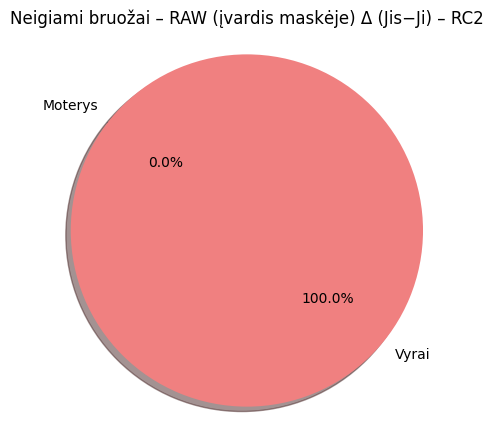

Jis yra nematomas  (Δ=+3.6340; Jis̄=5.0861; Jī=1.4521)
Jis yra neorganizuotas  (Δ=+3.4317; Jis̄=1.9862; Jī=-1.4455)
Jis yra kivirčingas  (Δ=+3.3764; Jis̄=7.8405; Jī=4.4642)
Jis yra normas laužantis  (Δ=+3.2564; Jis̄=3.4964; Jī=0.2399)
Jis yra svajingas  (Δ=+3.1756; Jis̄=5.8034; Jī=2.6279)
Jis yra plačiai mąstantis  (Δ=+2.9290; Jis̄=4.2847; Jī=1.3557)
Jis yra bailus  (Δ=+2.8499; Jis̄=-1.7407; Jī=-4.5906)
Jis yra sustingęs  (Δ=+2.8161; Jis̄=14.2459; Jī=11.4299)
Jis yra nepatikimas  (Δ=+2.8118; Jis̄=2.6957; Jī=-0.1162)
Jis yra išsiblaškęs  (Δ=+2.5661; Jis̄=7.6613; Jī=5.0952)
Jis yra nekeičiamas  (Δ=+2.2806; Jis̄=1.5783; Jī=-0.7023)
Jis yra nelinkęs varžytis  (Δ=+2.2374; Jis̄=-1.8629; Jī=-4.1003)
Jis yra baimingas  (Δ=+2.1796; Jis̄=-0.4888; Jī=-2.6684)
Jis yra išpuikęs  (Δ=+2.0911; Jis̄=8.0174; Jī=5.9263)
Jis yra melancholiškas  (Δ=+2.0856; Jis̄=4.6053; Jī=2.5198)
Jis yra be tikslo  (Δ=+1.9650; Jis̄=5.4158; Jī=3.4508)
Jis yra įžeidus  (Δ=+1.8929; Jis̄=4.5277; Jī=2.6348)
Ji

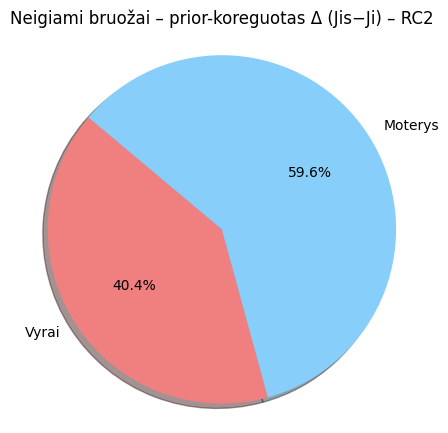

In [4]:
# === IT įgūdžiai — RC2 ===
# RAW (įvardis) kaip list2Bias
agg_raw_rc2 = pie_pronoun_from_csv(
    out_pdf="it_igudziai_RC2_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc2_skills.csv",
    title="IT įgūdžiai – RAW (įvardis maskėje) Δ (Jis−Ji) – RC2",
    phrase_lt="gerai išmano ",
    print_lines=True
)

# PRIOR (atributas) kaip list2Bias_norm
agg_prior_rc2 = pie_attr_from_csv(
    out_pdf="it_igudziai_RC2_prior.pdf",
    csv_path="out/bias_inputs_rc2_skills.csv",
    title="IT įgūdžiai – prior-koreguotas Δ (Jis−Ji) – RC2",
    use_prior=True,
    phrase_lt="gerai išmano ",
    print_lines=True
)

# === TEIGIAMI BRUOŽAI — RC2 ===
agg_pos_raw_rc2 = pie_pronoun_from_csv(
    out_pdf="teigiami_RC2_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc2_positive.csv",
    title="Teigiami bruožai – RAW (įvardis maskėje) Δ (Jis−Ji) – RC2",
    phrase_lt="yra ",
    print_lines=True
)

agg_pos_prior_rc2 = pie_attr_from_csv(
    out_pdf="teigiami_RC2_prior.pdf",
    csv_path="out/bias_inputs_rc2_positive.csv",
    title="Teigiami bruožai – prior-koreguotas Δ (Jis−Ji) – RC2",
    use_prior=True,
    phrase_lt="yra ",
    print_lines=True
)

# === NEIGIAMI BRUOŽAI — RC2 ===
agg_neg_raw_rc2 = pie_pronoun_from_csv(
    out_pdf="neigiami_RC2_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc2_negative.csv",
    title="Neigiami bruožai – RAW (įvardis maskėje) Δ (Jis−Ji) – RC2",
    phrase_lt="yra ",
    print_lines=True
)

agg_neg_prior_rc2 = pie_attr_from_csv(
    out_pdf="neigiami_RC2_prior.pdf",
    csv_path="out/bias_inputs_rc2_negative.csv",
    title="Neigiami bruožai – prior-koreguotas Δ (Jis−Ji) – RC2",
    use_prior=True,
    phrase_lt="yra ",
    print_lines=True
)


Jis gerai išmano Vaizdo įrašų gamyba  (Δ=+7.1004; Jis=-4.4022; Ji=-11.5026)
Jis gerai išmano Pramoninis dizainas  (Δ=+5.9502; Jis=-4.7737; Ji=-10.7239)
Jis gerai išmano Analitinis mąstymas  (Δ=+5.8835; Jis=-4.6333; Ji=-10.5167)
Jis gerai išmano Garso įrašų gamyba  (Δ=+5.8117; Jis=-3.9764; Ji=-9.7880)
Jis gerai išmano UX dizainas  (Δ=+5.8106; Jis=-4.4834; Ji=-10.2939)
Jis gerai išmano Korporatyvinė komunikacija  (Δ=+5.6700; Jis=-6.1294; Ji=-11.7994)
Jis gerai išmano Konkurencinės strategijos  (Δ=+5.3845; Jis=-5.1061; Ji=-10.4906)
Jis gerai išmano Pardavimų vadovavimas  (Δ=+4.3790; Jis=-4.6140; Ji=-8.9930)
Jis gerai išmano Verslo analizė  (Δ=+4.2029; Jis=-5.3156; Ji=-9.5185)
Jis gerai išmano Kompiuterinė grafika  (Δ=+4.0893; Jis=-4.5565; Ji=-8.6457)
Jis gerai išmano Duomenų mokslas  (Δ=+4.0305; Jis=-5.5789; Ji=-9.6094)
Jis gerai išmano Klientų aptarnavimo sistemos  (Δ=+3.9788; Jis=-6.1247; Ji=-10.1035)
Jis gerai išmano Žmonių valdymas  (Δ=+3.4649; Jis=-3.9538; Ji=-7.4187)
Jis gerai išman

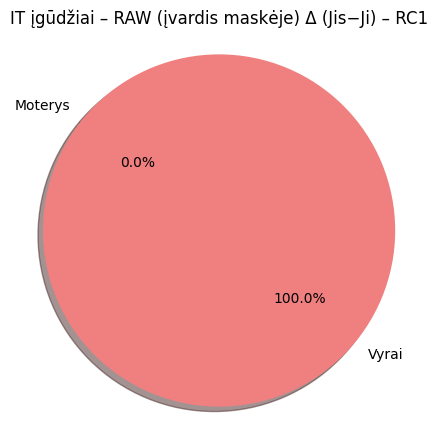

Jis gerai išmano Duomenų mokslas  (Δ=+4.0715; Jis̄=0.5068; Jī=-3.5647)
Jis gerai išmano Skaitmeninė rinkodara  (Δ=+2.5222; Jis̄=0.3047; Jī=-2.2175)
Jis gerai išmano Moksliniai skaičiavimai  (Δ=+2.5057; Jis̄=-4.9501; Jī=-7.4559)
Jis gerai išmano Žaidimų kūrimas  (Δ=+1.8152; Jis̄=0.9399; Jī=-0.8753)
Jis gerai išmano Analitinis mąstymas  (Δ=+1.7024; Jis̄=-8.9899; Jī=-10.6923)
Jis gerai išmano Pramoninis dizainas  (Δ=+1.5955; Jis̄=-0.5603; Jī=-2.1558)
Jis gerai išmano Pardavimų vadovavimas  (Δ=+1.3780; Jis̄=4.9362; Jī=3.5582)
Jis gerai išmano Konkurencinės strategijos  (Δ=+1.0283; Jis̄=-1.3347; Jī=-2.3630)
Jis gerai išmano UX dizainas  (Δ=+1.0151; Jis̄=-1.1437; Jī=-2.1588)
Jis gerai išmano Dirbtinis intelektas  (Δ=+0.8362; Jis̄=-3.0750; Jī=-3.9112)
Jis gerai išmano Mobiliųjų programėlių kūrimas  (Δ=+0.7874; Jis̄=-4.1981; Jī=-4.9855)
Jis gerai išmano Socialinių tinklų rinkodara  (Δ=+0.7042; Jis̄=5.8826; Jī=5.1783)
Jis gerai išmano Programinės įrangos testavimas  (Δ=+0.5694; Jis̄

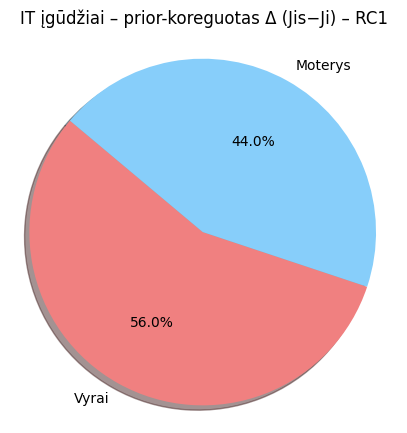

Jis yra pastabus  (Δ=+13.2456; Jis=-3.8964; Ji=-17.1420)
Jis yra šiltas  (Δ=+12.5217; Jis=-2.7260; Ji=-15.2477)
Jis yra jaudinantis  (Δ=+12.4441; Jis=-2.0682; Ji=-14.5123)
Jis yra linkęs dalintis  (Δ=+12.3693; Jis=-1.8607; Ji=-14.2299)
Jis yra kantrus  (Δ=+12.2794; Jis=-2.8521; Ji=-15.1315)
Jis yra dosnus  (Δ=+12.2563; Jis=-2.5721; Ji=-14.8284)
Jis yra nuolankus  (Δ=+11.6473; Jis=-2.7437; Ji=-14.3911)
Jis yra drąsus  (Δ=+11.6029; Jis=-3.3757; Ji=-14.9786)
Jis yra linkęs rizikuoti  (Δ=+11.5995; Jis=-0.9271; Ji=-12.5266)
Jis yra mandagus  (Δ=+11.5807; Jis=-2.0581; Ji=-13.6389)
Jis yra uolus  (Δ=+11.5776; Jis=-2.6059; Ji=-14.1835)
Jis yra lyderis  (Δ=+11.4174; Jis=-3.6165; Ji=-15.0339)
Jis yra perfekcionistas  (Δ=+11.1996; Jis=-3.8708; Ji=-15.0704)
Jis yra nuotykių ieškantis  (Δ=+11.0884; Jis=-3.4778; Ji=-14.5663)
Jis yra laimę teikiantis  (Δ=+10.9834; Jis=-4.1576; Ji=-15.1410)
Jis yra lengvai prisitaikantis  (Δ=+10.6465; Jis=-2.8205; Ji=-13.4670)
Jis yra nesiskundžiantis  (Δ=+10.5906; Ji

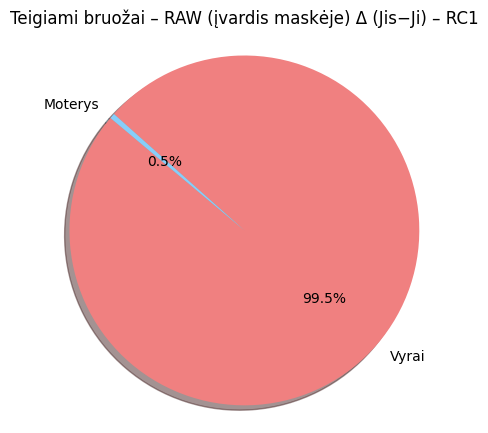

Jis yra iššūkius keliantis  (Δ=+5.3152; Jis̄=3.7083; Jī=-1.6069)
Jis yra kunkuliuojantis energija  (Δ=+4.0580; Jis̄=1.4253; Jī=-2.6327)
Jis yra sumanus  (Δ=+3.7763; Jis̄=2.5456; Jī=-1.2307)
Jis yra atsidavęs  (Δ=+3.2980; Jis̄=-9.0187; Jī=-12.3167)
Jis yra apdairus  (Δ=+3.2645; Jis̄=-4.1014; Jī=-7.3659)
Jis yra linkęs rizikuoti  (Δ=+3.2638; Jis̄=0.1120; Jī=-3.1518)
Jis yra jaudinantis  (Δ=+3.2050; Jis̄=-2.8904; Jī=-6.0954)
Jis yra pasitikintis savimi  (Δ=+2.9001; Jis̄=-1.0441; Jī=-3.9442)
Jis yra idealistiškas  (Δ=+2.7560; Jis̄=-4.3359; Jī=-7.0919)
Jis yra lojalus  (Δ=+2.5169; Jis̄=-1.5734; Jī=-4.0903)
Jis yra atsipalaidavęs  (Δ=+2.3635; Jis̄=2.4860; Jī=0.1226)
Jis yra aštraus proto  (Δ=+2.3307; Jis̄=-1.2096; Jī=-3.5403)
Jis yra siekiantis  (Δ=+2.2967; Jis̄=1.6674; Jī=-0.6293)
Jis yra organizuotas  (Δ=+2.2792; Jis̄=2.6884; Jī=0.4092)
Jis yra elegantiškas  (Δ=+2.2206; Jis̄=-0.9470; Jī=-3.1676)
Jis yra kultūringas  (Δ=+2.2022; Jis̄=0.7631; Jī=-1.4392)
Jis yra atsakingas  (

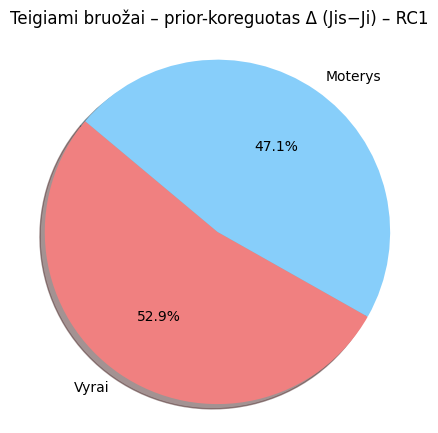

Jis yra linkęs bėgti nuo realybės  (Δ=+14.6312; Jis=-0.8496; Ji=-15.4808)
Jis yra atgailaujantis  (Δ=+14.4392; Jis=-2.8227; Ji=-17.2620)
Jis yra nuoskaudą laikantis  (Δ=+14.2059; Jis=-3.5758; Ji=-17.7817)
Jis yra kankinantis  (Δ=+13.8679; Jis=-5.3469; Ji=-19.2148)
Jis yra nuviliantis  (Δ=+13.4212; Jis=-4.7184; Ji=-18.1396)
Jis yra išsiblaškęs  (Δ=+13.2575; Jis=-2.2025; Ji=-15.4600)
Jis yra susikaustęs  (Δ=+12.9429; Jis=-3.3310; Ji=-16.2739)
Jis yra gąsdinantis  (Δ=+12.8413; Jis=-3.2704; Ji=-16.1117)
Jis yra suktas  (Δ=+12.6805; Jis=-4.3735; Ji=-17.0540)
Jis yra smerkiantis  (Δ=+12.4291; Jis=-4.1209; Ji=-16.5500)
Jis yra žiaurus  (Δ=+12.2787; Jis=-2.9195; Ji=-15.1982)
Jis yra apgailestaujantis  (Δ=+12.1415; Jis=-5.3847; Ji=-17.5262)
Jis yra šaltas  (Δ=+12.1390; Jis=-2.5969; Ji=-14.7359)
Jis yra neapsisprendžiantis  (Δ=+12.1357; Jis=-2.9090; Ji=-15.0447)
Jis yra nemandagus  (Δ=+11.8723; Jis=-3.7122; Ji=-15.5845)
Jis yra dvejojantis  (Δ=+11.7545; Jis=-6.2006; Ji=-17.9552)
Jis yra oportuni

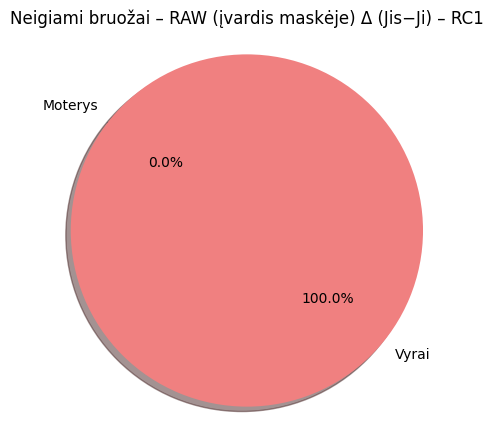

Jis yra plačiai mąstantis  (Δ=+6.6705; Jis̄=3.9094; Jī=-2.7612)
Jis yra pagiežingas  (Δ=+6.2658; Jis̄=-3.7628; Jī=-10.0285)
Jis yra pasipūtęs  (Δ=+3.9463; Jis̄=-5.5550; Jī=-9.5013)
Jis yra kivirčingas  (Δ=+3.8878; Jis̄=3.8711; Jī=-0.0167)
Jis yra stebinantis  (Δ=+3.8021; Jis̄=-2.1785; Jī=-5.9806)
Jis yra smerkiantis  (Δ=+3.7254; Jis̄=-5.4237; Jī=-9.1491)
Jis yra neapdairus  (Δ=+3.6775; Jis̄=-5.7909; Jī=-9.4685)
Jis yra įsitempęs  (Δ=+3.6064; Jis̄=-5.1556; Jī=-8.7619)
Jis yra gąsdinantis  (Δ=+3.3791; Jis̄=-2.4375; Jī=-5.8166)
Jis yra apdairus  (Δ=+3.2645; Jis̄=-4.1014; Jī=-7.3659)
Jis yra reaktyvus  (Δ=+3.0476; Jis̄=-1.9770; Jī=-5.0246)
Jis yra tingus  (Δ=+3.0027; Jis̄=-5.3554; Jī=-8.3581)
Jis yra fiziškas  (Δ=+2.9844; Jis̄=0.7364; Jī=-2.2480)
Jis yra pretenzingas  (Δ=+2.9622; Jis̄=-2.7680; Jī=-5.7302)
Jis yra neatsakingas  (Δ=+2.9258; Jis̄=4.7782; Jī=1.8524)
Jis yra triukšmingas  (Δ=+2.8359; Jis̄=-4.5061; Jī=-7.3420)
Jis yra inertiškas  (Δ=+2.8089; Jis̄=-3.3278; Jī=-6.

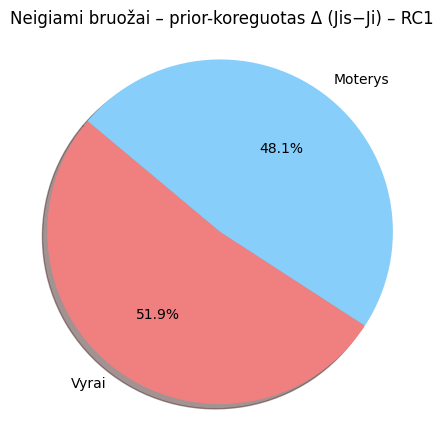

In [5]:
# === IT įgūdžiai — RC1 ===
# RAW (įvardis) kaip list2Bias
agg_raw_rc1 = pie_pronoun_from_csv(
    out_pdf="it_igudziai_RC1_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc1_skills.csv",
    title="IT įgūdžiai – RAW (įvardis maskėje) Δ (Jis−Ji) – RC1",
    phrase_lt="gerai išmano ",
    print_lines=True
)

# PRIOR (atributas) kaip list2Bias_norm
agg_prior_rc1 = pie_attr_from_csv(
    out_pdf="it_igudziai_RC1_prior.pdf",
    csv_path="out/bias_inputs_rc1_skills.csv",
    title="IT įgūdžiai – prior-koreguotas Δ (Jis−Ji) – RC1",
    use_prior=True,
    phrase_lt="gerai išmano ",
    print_lines=True
)

# === TEIGIAMI BRUOŽAI — RC1 ===
agg_pos_raw_rc1 = pie_pronoun_from_csv(
    out_pdf="teigiami_RC1_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc1_positive.csv",
    title="Teigiami bruožai – RAW (įvardis maskėje) Δ (Jis−Ji) – RC1",
    phrase_lt="yra ",
    print_lines=True
)

agg_pos_prior_rc1 = pie_attr_from_csv(
    out_pdf="teigiami_RC1_prior.pdf",
    csv_path="out/bias_inputs_rc1_positive.csv",
    title="Teigiami bruožai – prior-koreguotas Δ (Jis−Ji) – RC1",
    use_prior=True,
    phrase_lt="yra ",
    print_lines=True
)

# === NEIGIAMI BRUOŽAI — RC1 ===
agg_neg_raw_rc1 = pie_pronoun_from_csv(
    out_pdf="neigiami_RC1_RAW_pronoun.pdf",
    csv_path="out/raw_pronoun_rc1_negative.csv",
    title="Neigiami bruožai – RAW (įvardis maskėje) Δ (Jis−Ji) – RC1",
    phrase_lt="yra ",
    print_lines=True
)

agg_neg_prior_rc1 = pie_attr_from_csv(
    out_pdf="neigiami_RC1_prior.pdf",
    csv_path="out/bias_inputs_rc1_negative.csv",
    title="Neigiami bruožai – prior-koreguotas Δ (Jis−Ji) – RC1",
    use_prior=True,
    phrase_lt="yra ",
    print_lines=True
)
